## 1.4 Support Vector Machines

**Support vector machines** (SVMs) are a set of supervised learning methods for classification, regression, and detection of outliers.

Advantages of SVMs:
* Effective in high dimensional spaces
* Still effective in cases where number of dimensions is greater than number of samples
* Uses subset or training points in decision function (support vectors), so it's memory efficient
* Versatile, different Kernel functions can be specified

Disadvantages of SVMs:
* If number of features is much greater than number of samples, need to avoid overfitting through choice of Kernel functions and regularization term
* SVMs do not provide probability estimates directly, rather these are calculated using an expensive five-fold cross validation

### 1.4.1 Classification

Some common classes capable of performing binary and multi-class classification on a dataset:
* `SVC`
* `NuSVC`
* `LinearSVC`

`SVC` and `NuSVC`are similar but accept different parameter sets. `LinearSVC` is a faster implementation for the case of a linear kernel; note that `LinearSVC` does not take the `kernel` parameter because it assumes a linear kernel.

###### Example

In [2]:
from sklearn import svm

In [3]:
X = [[0,0], [1,1]]
y = [0,1]

In [5]:
clf = svm.SVC()
clf.fit(X,y)

SVC()

In [6]:
clf.predict([[2,2]])

array([1])

In [7]:
#get support vectors
clf.support_vectors_

array([[0., 0.],
       [1., 1.]])

In [8]:
#get indices of support vectors
clf.support_

array([0, 1])

In [9]:
#get number of support vectors for each class
clf.n_support_

array([1, 1])

###### Example - SVM: maximum margin separating hyperplane

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs

In [11]:
# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

#fit model, don't regularize (for illustration purposes)
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

SVC(C=1000, kernel='linear')

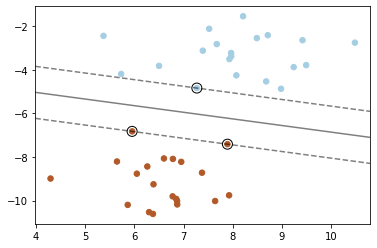

In [12]:
#copypasta
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

###### Example - Non-linear SVM

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

In [14]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3,3,500))

np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:,1] > 0)

In [15]:
#fit the model
clf = svm.NuSVC(gamma = 'auto')
clf.fit(X, Y)

NuSVC(gamma='auto')

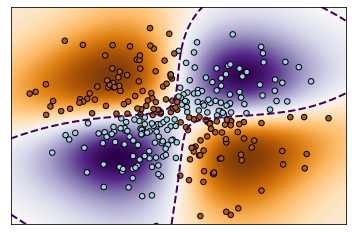

In [16]:
#copypasta
# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

###### Example - SVM-ANOVA: SVM with univariate feature selection

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [18]:
#import data
X, y = load_iris(return_X_y = True)

#add non-informative features
np.random.seed(0)
X = np.hstack((X, 2 * np.random.random((X.shape[0], 36))))

In [19]:
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc', SVC(gamma = 'auto'))])

In [20]:
#plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1,3,6,10,15,20,30,40,60,80,100)

for percentile in percentiles:
    clf.set_params(anova__percentile = percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

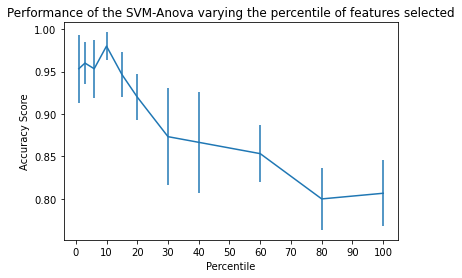

In [21]:
#copypasta
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()

#### 1.4.1.1 Multi-class classification

In [22]:
X = [[0],[1],[2],[3]]
Y = [0,1,2,3]

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X,Y)

SVC(decision_function_shape='ovo')

In [23]:
dec = clf.decision_function([[1]])
dec.shape[1]

6

In [24]:
clf.decision_function_shape = 'ovr'

dec = clf.decision_function([[1]])
dec.shape[1]

4

In [25]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X,Y)

LinearSVC()

In [26]:
dec = lin_clf.decision_function([[1]])
dec.shape[1]

4

###### Example: Plot different SVM classifiers in the iris dataset

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

In [28]:
#copypasta
def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


In [29]:
#copypasta
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [30]:
#import data
iris = datasets.load_iris()

#take first two features
X = iris.data[:, :2]
y = iris.target

In [31]:
#create instance of SVM and fit the data
#we do not scale since we want to plot support vectors

C = 1.0 #SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
                 svm.LinearSVC(C=C, max_iter=10000),
                 svm.SVC(kernel='rbf', gamma=0.7, C=C),
                 svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))

models = (clf.fit(X, y) for clf in models)

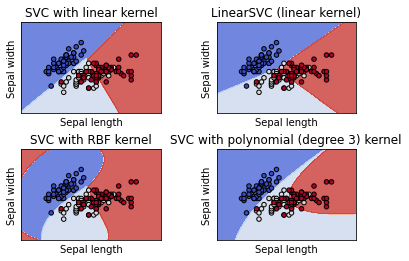

In [32]:
#copypasta
# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("Sepal length")
    ax.set_ylabel("Sepal width")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

#### 1.4.1.2 Scores and probabilities
#### 1.4.1.3 Unbalanced problems

###### Example - SVM: Separating hyperplane for unbalanced classes
https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py

###### Example - SVM: weighted samples
https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html#sphx-glr-auto-examples-svm-plot-weighted-samples-py

### 1.4.2 Regression

Support Vector Classification methods can be extended to solve regression problems. There are three different implementations:
* SVR
* NuSVR
* LinearSVR

Example:

In [33]:
from sklearn import svm

In [34]:
X = [[0,0], [2,2]]
y = [0.5, 2.5]

In [35]:
regr = svm.SVR()
regr.fit(X,y)

SVR()

In [36]:
regr.predict([[1,1]])

array([1.5])

###### Example - Support Vector Regression (SVR) using linear and non-linear kernels

In [37]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [38]:
#generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis = 0)
y = np.sin(X).ravel()

In [39]:
#add noise
y[::5] += 3 * (0.5 - np.random.rand(8))

In [41]:
#fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=0.1, coef0=1)

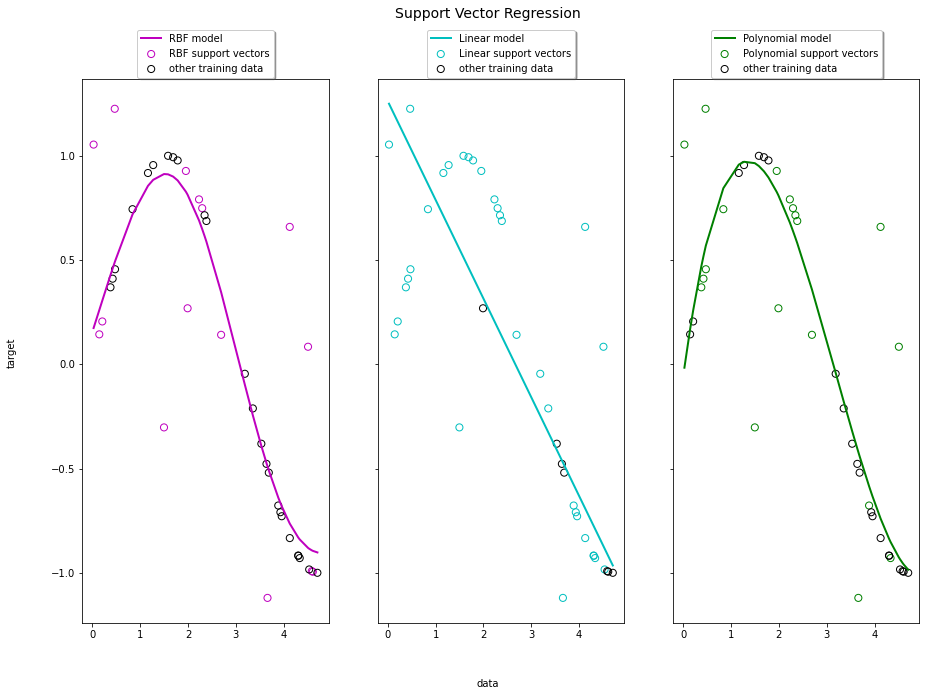

In [42]:
#copypasta
# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Linear", "Polynomial"]
model_color = ["m", "c", "g"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        X,
        svr.fit(X, y).predict(X),
        color=model_color[ix],
        lw=lw,
        label="{} model".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[np.setdiff1d(np.arange(len(X)), svr.support_)],
        y[np.setdiff1d(np.arange(len(X)), svr.support_)],
        facecolor="none",
        edgecolor="k",
        s=50,
        label="other training data",
    )
    axes[ix].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

### 1.4.3 Density estimation, novelty detection

### 1.4.4 Complexity

### 1.4.5 Tips on practical use

* Avoiding data copy
* Kernel cache size
* Setting C
* Highly recommended to scale your data
* Shrinking parameter: "*We found that if the number of iterations is large, then shrinking can shorten the training time. However, if we loosely solve the optimization problem (e.g., by using a large stopping tolerance), the code without using shrinking may be much faster*"
* Parameter `nu=` in `NuSVC` / `OneClassSVM` / `NuSVR` approximates the fraction of training errors and support vectors
* In `SVC` set `class_weight='balanced'` if the data is unbalanced
* Randomness of the underlying implementations
* Using L1 penalization like `LinearSVC(penalty='l1', dual=False)` yields a sparse solution

### 1.4.6 Kernel functions

The kernel function can be:
* linear
* polynomial
* rbf (radial basis function)
* sigmoid

And is specified by the `kernel=` parameter

In [44]:
linear_svc = svm.SVC(kernel='linear')
linear_svc.kernel

'linear'

In [45]:
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.kernel

'rbf'

#### 1.4.6.1 Parameters of the RBF kernel

###### Example - RBM SVM parameters

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [47]:
#copypasta
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [49]:
#load and prepare data
# we only keep the first two features in X and sub-sample the dataset
# to keep only 2 classes and make it a binary classification problem

iris = load_iris()
X = iris.data
y = iris.target

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

In [50]:
#scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

In [51]:
#train classifiers
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [52]:
print(f"Best params: {grid.best_params_}")
print(f"With score of: {grid.best_score_}")

Best params: {'C': 1.0, 'gamma': 0.1}
With score of: 0.9666666666666668


In [53]:
#now fit a classifier for all parameters in the 2d version
#copypasta
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

<ipython-input-54-33b62c4913f7>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
<ipython-input-54-33b62c4913f7>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
<ipython-input-54-33b62c4913f7>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X an

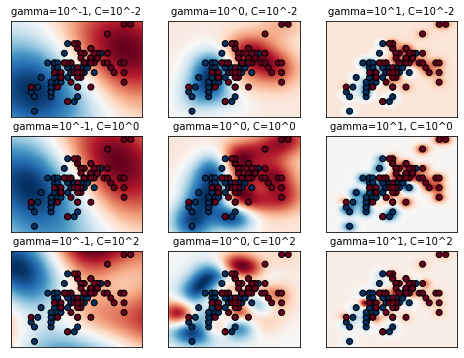

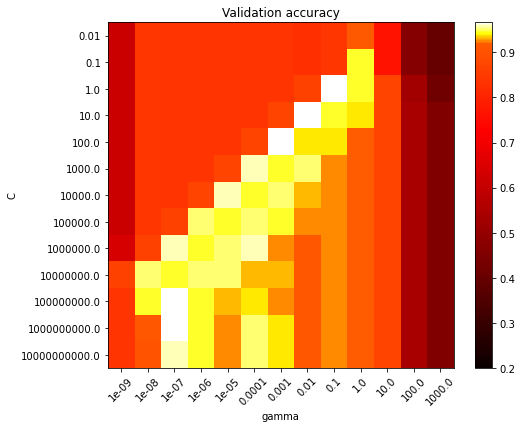

In [54]:
#copypasta
# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

###### Example - Non-linear SVM

In [55]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm

In [56]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(0)

X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

In [57]:
clf = svm.NuSVC(gamma='auto')
clf.fit(X, Y)

NuSVC(gamma='auto')

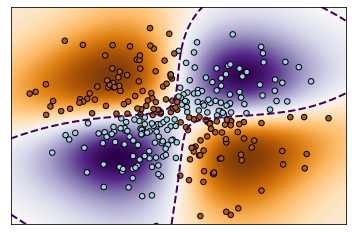

In [58]:
#copypasta
# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

#### 1.4.6.2 Custom Kernels

Classifiers with custom kernels because the same way as other classifiers, except:
* Field `support_vectors` is now empty, only indices of support vectors are stored in `support_`
* A reference (not copy) of the first argument in the `fit()` method is stored for future reference. If that array changes between `fit()` and `predict()` you will have unexpected results

##### 1.4.6.2.1 Using Python functions as kernels

Example:

In [59]:
import numpy as np
from sklearn import svm

In [60]:
def my_kernel(X, Y):
    return np.dot(X, Y.T)

clf = svm.SVC(kernel=my_kernel)

###### Example - SVM with custom kernel

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets

In [62]:
#import data
iris = datasets.load_iris()

X = iris.data[:, :2]
Y = iris.target

In [63]:
#copypasta
def my_kernel(X, Y):
    """
    We create a custom kernel:

                 (2  0)
    k(X, Y) = X  (    ) Y.T
                 (0  1)
    """
    M = np.array([[2, 0], [0, 1.0]])
    return np.dot(np.dot(X, M), Y.T)


h = 0.02  # step size in the mesh

In [64]:
#create an instance of SVM and fit the data
clf = svm.SVC(kernel=my_kernel)
clf.fit(X, Y)

SVC(kernel=<function my_kernel at 0x000001ECD9375AF0>)

<ipython-input-65-9054de8db062>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


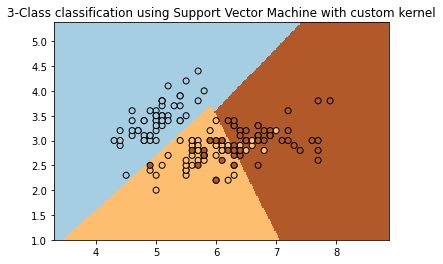

In [65]:
#copypasta

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.title("3-Class classification using Support Vector Machine with custom kernel")
plt.axis("tight")
plt.show()

##### 1.4.6.2.2 Using the Gram Matrix

You can pass pre-computed kernels using `kernel='precomputed` and then pass Gram matrix instead of X to the `fit` and `predict` methods. The kernel values between *all* training vectors and the test vectors must be provided.

Example:

In [66]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm

In [67]:
X, y = make_classification(n_samples=10, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [68]:
clf = svm.SVC(kernel='precomputed')

gram_train = np.dot(X_train, X_train.T)

clf.fit(gram_train, y_train)

SVC(kernel='precomputed')

In [69]:
gram_test = np.dot(X_test, X_train.T)
clf.predict(gram_test)

array([0, 1, 0])

### 1.4.7 Mathematical formulation
#### 1.4.7.1 SVC
#### 1.4.7.2 LinearSVC
#### 1.4.7.3 NuSVC
#### 1.4.7.4 SVR
#### 1.4.7.5 LinearSVR

### 1.4.8 Implementation details